# Exercise 2.1

In [59]:
using DistMesh
using Plots
using SparseArrays
using Polynomials

In [3]:
function xy(x0::Float64, y0::Float64, L1::Float64, L2::Float64, noelms1::Int64, noelms2::Int64)
    # Computes the x-coordinates and y-coordinates in a given range, with a given grid definition.
    # Author: Clara Hollenbeck
    # x0, y0: minimum x and y value
    # L1, L", maximum x and y value respectively
    # noelms1, noelms2: no. of elements in the x and y direction respectively.

    VX= repeat(collect(LinRange(x0, x0 + L1, noelms1+1)), inner = noelms2+1)
    VY = repeat(collect(LinRange(y0 + L2, y0, noelms2+1)), noelms1+1)
    return VX, VY
end

xy (generic function with 1 method)

In [4]:
function conelmtab(noelms1::Int64, noelms2::Int64)
    novertices = noelms1 *noelms2*2
    EToV = zeros(Int64, novertices, 3)

    for i in 1: noelms1
        v1 = collect(range(1, noelms2)) .+ (noelms2+1)*(i-1)
        v2 = collect(range(noelms2 + 3, 2*noelms2+2)) .+ (noelms2+1)*(i-1)
        v3 = collect(range(noelms2 + 2, 2*noelms2 +1)) .+ (noelms2+1)*(i-1)
        v4 = collect(range(2 , noelms2+1)) .+ (noelms2+1)*(i-1)

        
        EToV[1 + noelms2*2 *(i-1) : noelms2*2 *i , :] = vcat(hcat(v1,v2,v3), hcat(v1, v4, v2))

    end
    return EToV[sortperm(EToV[:, 1]), :]

end


conelmtab (generic function with 1 method)

# Exercise 2.2

In [5]:
function basfun(n,VX,VY,EToV)
    i1 = EToV[n,1]
    i2 = EToV[n,2]
    i3 = EToV[n,3]
    abc = zeros(3,3)

    m = 1
    
    for (j, k) in ((i2, i3), (i3, i1), (i1, i2))
        abc[m, 1] = VX[j]*VY[k] - VX[k]*VY[j] 
        abc[m, 2] = VY[j] - VY[k] 
        abc[m, 3] = VX[k]- VX[j] 
        m += 1
    end


    delta = 1/2 *(abc[1,1] + abc[2,1] + abc[3,1])
    return abc, delta

end

basfun (generic function with 1 method)

In [6]:
function  outernormal(n,k,VX,VY,EToV)
    k2 = ((k+1)%3 +1)
    dx =  VX[EToV[n, k2]] - VX[EToV[n, k]]
    dy =  VY[EToV[n, k2]] - VY[EToV[n, k]]

    norm = [dy; -dx]./sqrt(dx^2+dy^2)

    return norm
end

outernormal (generic function with 1 method)

In [7]:
n = 4
k = 2
x0 = -2.5
y0 = -4.8
L1 = 7.6
L2 = 5.9
noelm1 = 4
noelm2 = 3
VX, VY = xy(x0, y0, L1, L2, noelm1, noelm2)
EToV = conelmtab(noelm1, noelm2)
abc, delta = basfun(n, VX, VY, EToV)
norm = outernormal(n,k,VX,VY,EToV)
display(abc)
display(delta)
display(norm)

3×3 Matrix{Float64}:
  5.38333   0.0       1.9
 -6.56333  -1.96667  -1.9
  4.91667   1.96667   0.0

1.8683333333333332

2-element Vector{Float64}:
  1.0
 -0.0

# Exercise 2.3

In [8]:
function assembly(VX,VY,EToV,lam1,lam2,qt)
    M = length(VX)
    N, _ = size(EToV)

    A = zeros(M,M)
    b = zeros(M)

    for n in 1:N
        abc, delta = basfun(n, VX, VY, EToV)
        q = abs(delta)/9* sum(qt[EToV[n, :]])

        for r in 1:3
            i = EToV[n,r]
            b[i] += q
            
            for s in 1:3
                j = EToV[n,s]
                kn = 1/(4*abs(delta))*(lam1*abc[r,2]*abc[s,2] + lam2*abc[r,3]*abc[s,3])
                A[i,j] += kn 
            end
        end
    end
    return A, b

end

assembly (generic function with 1 method)

# Exercise 2.4

In [34]:
function dirbc(bnodes,f,A,b)
    M = length(b)
   
    for (k,i) in enumerate(bnodes)
        b[i] = f[k]
        A[i, i] = 0

        idx = findall(!iszero, A[:, i])
        b[idx] .-= A[idx, i].*f[k]  
        A[idx, i] .= 0
        A[i, idx] .= 0

        A[i,i] = 1
 
    end
    return A, b
end


dirbc (generic function with 1 method)

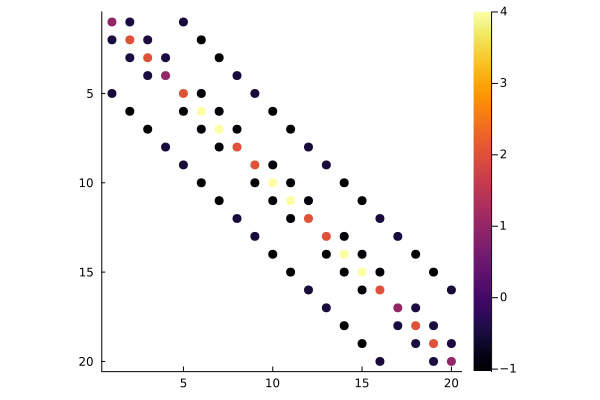

20-element Vector{Float64}:
 -22.290000000000003
 -10.457222222222226
   9.111111111111109
  36.415
  -0.40199999999999925
 -11.71073740377309
  16.988648561139193
  23.552
   0.5479999999999998
 -42.566798493408655
 -26.5413540489642
  32.349
  21.71399999999999
  95.66445656986153
 220.90473142366272
 103.95999999999998
 104.24999999999997
 154.94411111111106
 213.37377777777775
 279.539

In [40]:
#=
x0, y0 = (0.0,0.0)
L1, L2 = (1.0,1.0)
noelm1, noelm2 = (4,4)
q(x,y) = 0
=#

n = 4
k = 2
x0 = -2.5
y0 = -4.8
L1 = 7.6
L2 = 5.9
noelm1 = 4
noelm2 = 3
q(x,y) = -6x + 2y - 2
f(x,y) = x^3 - x^2*y + y^2 - 1



lam1= 1
lam2 = 1
VX, VY = xy(x0, y0, L1, L2, noelm1, noelm2)
EToV = conelmtab(noelm1, noelm2)

bnodes = union(reduce(vcat, [findall(VX .== x0 ), findall(VY.== y0), findall((VX .== (L1+x0 ))), findall(VY.== (L2+y0))]))
qt = q.(VX, VY)
ft = f.(VX[bnodes], VY[bnodes])


A, b = assembly(VX,VY,EToV,lam1,lam2,qt)
A ,b = dirbc(bnodes,ft,A,b)


spy(A, markersize = 5)
display(b)



# Exercise 2.5

In [43]:
function solveBVP(x0, y0, L1, L2, noelm1, noelm2, q, f)
    VX, VY = xy(x0, y0, L1, L2, noelm1, noelm2)
    EToV = conelmtab(noelm1, noelm2)

    bnodes = union(reduce(vcat, [findall(VX .== x0 ), findall(VY.== y0), findall((VX .== (L1+x0 ))), findall(VY.== (L2+y0))]))
    ft = f.(VX[bnodes], VY[bnodes])
    qt= q.(VX, VY)

    
    A, b = assembly(VX,VY,EToV,1,1,qt)
    A ,b = dirbc(bnodes,ft,A,b)

    u = A\b

    error = maximum(abs, u .- f.(VX, VY))
    return u, error
end

solveBVP (generic function with 1 method)

-1.9700959376440124

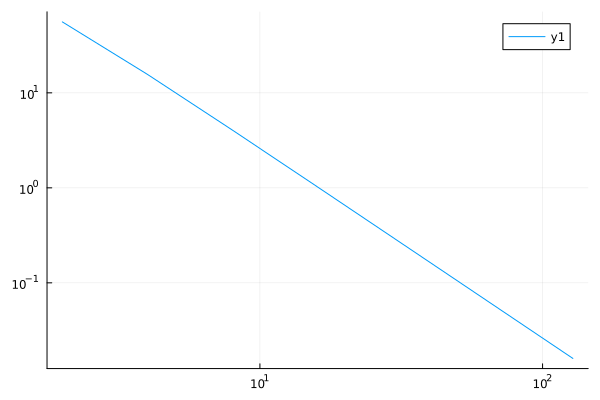

In [61]:
u(x,y) = x^3 - x^2*y + y^2 - 1
q(x,y) = -(6*x -2*y + 2)


u(x,y) = x^2*y^2
q(x,y) = -(2*y^2 + 2*x^2)


x0 = -2.5
y0 = -4.8
L1 = 7.6
L2 = 5.9
noelm1 = 4
noelm2 = 4
N = 7
es = zeros(N)
noelm = zeros(Int64, N)

for i in 1:N
    noelm[i] = 2^i
    

    us, e = solveBVP(x0, y0, L1, L2, noelm[i], noelm[i], q, u)
    es[i] = e


end

display(fit(log10.(noelm), log10.(es), 1)[1])
plot(noelm, es,  xaxis=:log10, yaxis=:log10)








In [ ]:
 
 fd = @(p) -min(min(min(1+p(:,2),1-p(:,2)),1+p(:,1)),1-p(:,1));
  fh = @(p) ones(size(p,1),1);
  [p,t] = distmesh( fd, fh, 0.2, [-1,-1;1,1], [-1,-1;-1,noel1;1,-1;1,1] );
  patch( 'vertices', p, 'faces', t, 'facecolor', [.9, .9, .9] )

LoadError: LoadError: UndefVarError: `@p` not defined
in expression starting at In[6]:2